In [1]:
import numpy as np
import xarray as xr
import extremespaper as ex
import viz
import mplRC
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cftime
import datetime as dt
import os
import glob
import matplotlib.cm as mcm

mplRC.paperRC2()

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy39dc/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


#### start with temperature events relative to historical ~1995 level (midpoint of historical slice), no adaptation
A) historical 95th percentile extreme days, non-seasonal definition, raw basis (relative to 1975-2014)

C) historical 95th percentile extreme days, seasonal definition, raw basis (relative to 1975-2014)

E) 40-year window MMMm running mean (~95th percentile) threshold, non-seasonal (relative to previous 40 years)

In [2]:
qq=.95
freq='daily'
chdef0={'time':-1,'lat':90,'lon':90}
scenref='ESM4_historical_D1'
yrspanref=ex.dictScenDates[scenref]
dirstr={1:'max',-1:'min'}

vstrs={'tos':'SST',
       'hplusos':'Surface H$^+$',
       'omega_arag_0':'Surface $\Omega _{a}$',
       'o2_mean_100_600':'100-600m Mean O$_2$',
       'spco2':'Surface pCO$_2$',
        ('tos','hplusos'):'SST and Surface H$^+$',
        ('tos','omega_arag_0'):'SST and Surface $\Omega _{a}$',
        ('tos','spco2'):'SST and Surface $p$CO$_2$',
        ('tos','spco2','omega_arag_0',):'SST, $\Omega _{a}$, and $p$CO$_2$',
        ('tos','hplusos','omega_arag_0',):'SST, H$^+$, and $\Omega _{a}$'
      }

combolist=[('tos','hplusos'),
           ('tos','omega_arag_0'),
           ('tos','spco2'),]
           # ('tos','spco2','omega_arag_0',),
           # ('tos','hplusos','omega_arag_0',)] # list of tuples

In [3]:
ff={}
for combo in combolist:
    for iscen in ['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']:
        yrspan=ex.dictScenDates[iscen]
        fpath=ex.exstats_multi_path(combo,iscen,yrspan,scenref,yrspanref,freq,qq,calcDur=False)

        ff[(combo,iscen)]=xr.open_dataset(fpath)
        print(fpath)


/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_multi_GFDL-ESM4.1.ESM4_historical_D1.1975_2014.refESM4_historical_D1.1975_2014.daily.tos_hplusos.p95.0_5.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_multi_GFDL-ESM4.1.ESM4_ssp126_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos_hplusos.p95.0_5.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_multi_GFDL-ESM4.1.ESM4_ssp370_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos_hplusos.p95.0_5.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_multi_GFDL-ESM4.1.ESM4_historical_D1.1975_2014.refESM4_historical_D1.1975_2014.daily.tos_omega_arag_0.p95.0_5.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_multi_GFDL-ESM4.1.ESM4_ssp126_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos_omega_arag_0.p95.0_5.0.1x1.nc
/s

In [4]:
hist='ESM4_historical_D1'
s126='ESM4_ssp126_D1'
s370='ESM4_ssp370_D1'

In [5]:
proj=ccrs.Robinson(central_longitude=-150)#-170
lons=viz.lonvec1x1
lats=viz.latvec1x1
# #cm1=cmocean.cm.thermal
# cm3=cmocean.cm.thermal_r
# cm2=cmocean.cm.balance
# #cm1.set_bad('w',alpha=0)
# cm3.set_bad('w',alpha=0)
# cm2.set_bad('w',alpha=0)

# colors1 = cmocean.cm.thermal(np.linspace(.1, 1, 100))
# colors2 = np.zeros((1,4))
# colors2[:,-1]=1.
# cm1b = mcolors.LinearSegmentedColormap.from_list('kzerotherm',  np.vstack((colors2, colors1)))
# cm1b.set_bad('w',alpha=0)
# cm1=mcolors.LinearSegmentedColormap.from_list('kzerotherm2',  colors1)
# cm1.set_bad('w',alpha=0)
# cm1.set_under('k')

In [6]:
def plot_sns(ax,axti,ivar,cbax=None):
    cmin=1/(365*40)*100
    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)

    m=ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    if cbax: fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=cbax); cbax.set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    #fig.colorbar(m,cax=ax[1,3])
#     fig.suptitle(f'Extreme Event Days, No Adaptation, raw 1975-2014 95/5 reference,'
#                  f'{vstrs[ivar]}',y=1.03)

    for iax in (ax[0,0],ax[0,1],ax[1,0],ax[1,1]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('SSP1-2.6',pad=2)
    ax[0,1].set_title('SSP3-7.0',pad=2)
    ax[0,0].set_ylabel('SC',labelpad=1)
    ax[1,0].set_ylabel('SV',labelpad=1)
    axti.set_title(vstrs[ivar],pad=11)
    return fig,ax

global_extremes_seas_Multi_All_newcm.png


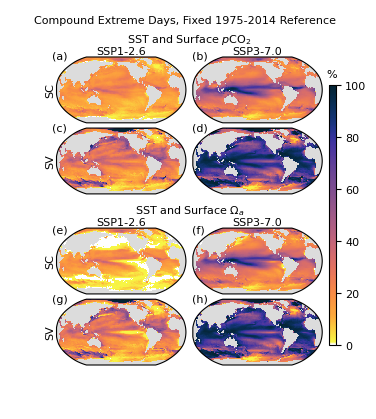

In [12]:

fig = plt.figure(figsize=(3.5, 4), constrained_layout=False)
og = fig.add_gridspec(2, 1, wspace=.1, hspace=.25)
axs={}
axt={}
iii=0
for b in range(2):
    # gridspec inside gridspec
    ig = og[b].subgridspec(2, 2, wspace=0.01, hspace=0.08)
    axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
    axt[iii]=fig.add_subplot(og[b])
    axt[iii].axis('off')
    iii+=1
cbax=fig.add_axes([.91,.16,.02,.65])
fig.suptitle(f'Compound Extreme Days, Fixed 1975-2014 Reference',y=.985)

plot_sns(axs[0],axt[0],('tos','spco2'),cbax)
plot_sns(axs[1],axt[1],('tos','omega_arag_0'),cbax)

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
axa.annotate('(a)',xy=(0.12, 0.875))
axa.annotate('(b)',xy=(0.52, 0.875))
axa.annotate('(c)',xy=(0.12, 0.695))
axa.annotate('(d)',xy=(0.52, 0.695))
axa.annotate('(e)',xy=(0.12, 0.44))
axa.annotate('(f)',xy=(0.52, 0.44))
axa.annotate('(g)',xy=(0.12, 0.268))
axa.annotate('(h)',xy=(0.52, 0.268))
figpath=f'global_extremes_seas_Multi_All_newcm.png'
print(figpath)
fig.savefig(figpath,dpi=300,bbox_inches='tight')

In [14]:

def plot_snsAdapt(ax,axti,ivar,cbax=None):
    cmin=1/(40*365)
    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    if cbax: fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=cbax); cbax.set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)

    #fig.suptitle(f'Extreme Event Days, 100-year Adaptation, raw 1975-2014 95/5 reference,'
    #             f'{vstrs[ivar]}',y=1.02)
    for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('Historical',pad=3)
    ax[0,1].set_title('SSP1-2.6',pad=3)
    ax[0,2].set_title('ssp3-7.0')
    ax[0,0].set_ylabel('SC',labelpad=3)
    ax[1,0].set_ylabel('SV',labelpad=3)
    axti.set_title(vstrs[ivar],pad=12)#,loc='left')
    return

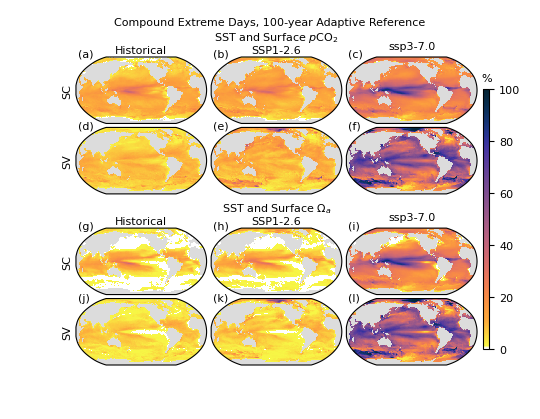

In [17]:
fig = plt.figure(figsize=(5.2, 4), constrained_layout=False)
og = fig.add_gridspec(2, 1, wspace=.1, hspace=.25)
axs={}
axt={}
iii=0
for b in range(2):
    # gridspec inside gridspec
    ig = og[b].subgridspec(2, 3, wspace=0.02, hspace=0.06)
    axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
    axt[iii]=fig.add_subplot(og[b])
    axt[iii].axis('off')
    iii+=1
cbax=fig.add_axes([.91,.15,.012,.65])

fig.suptitle(f'Compound Extreme Days, 100-year Adaptive Reference',y=.98)

plot_snsAdapt(axs[0],axt[0],('tos','spco2'),cbax)
plot_snsAdapt(axs[1],axt[1],('tos','omega_arag_0'))

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
axa.annotate('(a)',xy=(0.13, 0.88))
axa.annotate('(b)',xy=(0.39, 0.88))
axa.annotate('(c)',xy=(0.65, 0.88))
axa.annotate('(d)',xy=(0.13, 0.7))
axa.annotate('(e)',xy=(0.39, 0.7))
axa.annotate('(f)',xy=(0.65, 0.7))
axa.annotate('(g)',xy=(0.13, 0.45))
axa.annotate('(h)',xy=(0.39, 0.45))
axa.annotate('(i)',xy=(0.65, 0.45))
axa.annotate('(j)',xy=(0.13, 0.27))
axa.annotate('(k)',xy=(0.39, 0.27))
axa.annotate('(l)',xy=(0.65, 0.27))
fig.savefig(f'global_extremes_seasAdapt_Multi_All_newcm.png',
            dpi=300,bbox_inches='tight')

In [ ]:
break

In [ ]:
combo=('tos','hplusos')
fig,ax=plot_snsAdapt(combo)
figpath=f'/home/Elise.Olson/OAPMSE/extremesFigs/global_extremes_seasAdapt_{"_".join(combo)}.png'
print(figpath)
fig.savefig(figpath,dpi=300,bbox_inches='tight')

In [ ]:
combo=('tos','spco2')
fig,ax=plot_snsAdapt(combo)
figpath=f'/home/Elise.Olson/OAPMSE/extremesFigs/global_extremes_seasAdapt_{"_".join(combo)}.png'
print(figpath)
fig.savefig(figpath,dpi=300,bbox_inches='tight')

In [ ]:
combo=('tos','omega_arag_0')
fig,ax=plot_snsAdapt(combo)
figpath=f'/home/Elise.Olson/OAPMSE/extremesFigs/global_extremes_seasAdapt_{"_".join(combo)}.png'
print(figpath)
fig.savefig(figpath,dpi=300,bbox_inches='tight')

In [ ]:
combo=('tos','spco2','omega_arag_0')
fig,ax=plot_snsAdapt(combo)
figpath=f'/home/Elise.Olson/OAPMSE/extremesFigs/global_extremes_seasAdapt_{"_".join(combo)}.png'
print(figpath)
fig.savefig(figpath,dpi=300,bbox_inches='tight')

In [ ]:
combo=('tos','hplusos','omega_arag_0')
fig,ax=plot_snsAdapt(combo)
figpath=f'/home/Elise.Olson/OAPMSE/extremesFigs/global_extremes_seasAdapt_{"_".join(combo)}.png'
print(figpath)
fig.savefig(figpath,dpi=300,bbox_inches='tight')